In [8]:
from seqCNN_BVP_model import ComplexCNNFeatureExtractor, CNNLSTMWithBVP 
from NegPearCor import NegativePearsonCorrelation
from seqCNN_BVP_training import train_and_validate_cnnlstm_bvp
from seqCNN_BVP_test import test_model
from GradCAM import GradCAM, visualize_gradcam
from CNN_dataset import WindowedUBFCPhysDataset
# from CNN_dataset_augmented import WindowedUBFCPhysDataset

import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data loading & training

In [9]:

train_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Train"
test_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Test"
val_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Validation"


num_epochs = 10
learning_rate = 0.001
weight_decay = 0.0001
window_size = 20
stride = 15
batch_size = 16

train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir,
                                        window_size=window_size,
                                        stride=stride)
val_dataset   = WindowedUBFCPhysDataset(root_dir=val_dir,
                                        window_size=window_size,
                                        stride=stride)
test_dataset   = WindowedUBFCPhysDataset(root_dir=test_dir,
                                        window_size=window_size,
                                        stride=stride)


# needed when CNN_dataset_augmented is used
# train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir,
#                                         window_size=window_size,
#                                         stride=stride,p=0.7, isTrain=True)
# val_dataset   = WindowedUBFCPhysDataset(root_dir=val_dir,
#                                         window_size=window_size,
#                                         stride=stride, p=0.0, isTrain=False)
# test_dataset   = WindowedUBFCPhysDataset(root_dir=test_dir,
#                                         window_size=window_size,
#                                         stride=stride,p=0.0, isTrain=False)
                                        

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



for sequences, eda_targets, bvp_values in train_loader:
    print("Sequences shape:", sequences.shape)   # (B, T, 3, H, W)
    print("EDA shape:", eda_targets.shape)       # (B,) or (B, T)
    print("BVP shape:", bvp_values.shape)        # (B, T)
    break


import wandb
wandb.init(project="CNN_BVP_NORMALIZED_LAST_NPC", entity="aml-final-project")


cnn_feature_extractor = ComplexCNNFeatureExtractor()
model = CNNLSTMWithBVP(
    feature_extractor=cnn_feature_extractor, 
    hidden_size=256, 
    bvp_embed_size=32
)

# choose loss function 
criterion = nn.MSELoss()
# criterion = NegativePearsonCorrelation()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )

train_losses, val_losses, best_model = train_and_validate_cnnlstm_bvp(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    device = device,
    patience = 5
)


Sequences shape: torch.Size([16, 20, 3, 128, 128])
EDA shape: torch.Size([16, 20])
BVP shape: torch.Size([16, 20])


/home/ucloud/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/work/AML_Project/5_Models/CNN_dataset.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't hav

Epoch 1/10, Train Loss: 0.5942
Validation Loss: 1.6694
Validation loss decreased. Saving best model.
Epoch 2/10, Train Loss: 0.5569
Validation Loss: 1.6610
Validation loss decreased. Saving best model.
Epoch 3/10, Train Loss: 0.5538
Validation Loss: 1.7358
No improvement in validation loss for 1 epoch(s).
Epoch 4/10, Train Loss: 0.5815
Validation Loss: 1.7519
No improvement in validation loss for 2 epoch(s).
Epoch 5/10, Train Loss: 0.5671
Validation Loss: 1.7076
No improvement in validation loss for 3 epoch(s).
Epoch 6/10, Train Loss: 0.6189
Validation Loss: 1.6370
Validation loss decreased. Saving best model.
Epoch 7/10, Train Loss: 0.6269
Validation Loss: 1.9196
No improvement in validation loss for 1 epoch(s).
Epoch 8/10, Train Loss: 0.6700
Validation Loss: 1.5909
Validation loss decreased. Saving best model.
Epoch 9/10, Train Loss: 0.6394
Validation Loss: 1.6415
No improvement in validation loss for 1 epoch(s).
Epoch 10/10, Train Loss: 0.6380
Validation Loss: 1.4046
Validation loss

Epoch,▁▂▃▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▂▁▄▅▄▃▅▄▆▆█▇▇
Validation Loss,█▃▅▄▄▅▅▄▄▇▃▄▁
Epoch,10
Learning Rate,0.001
Train Loss,0.63801
Validation Loss,1.4046


### Train & Val Loss plot

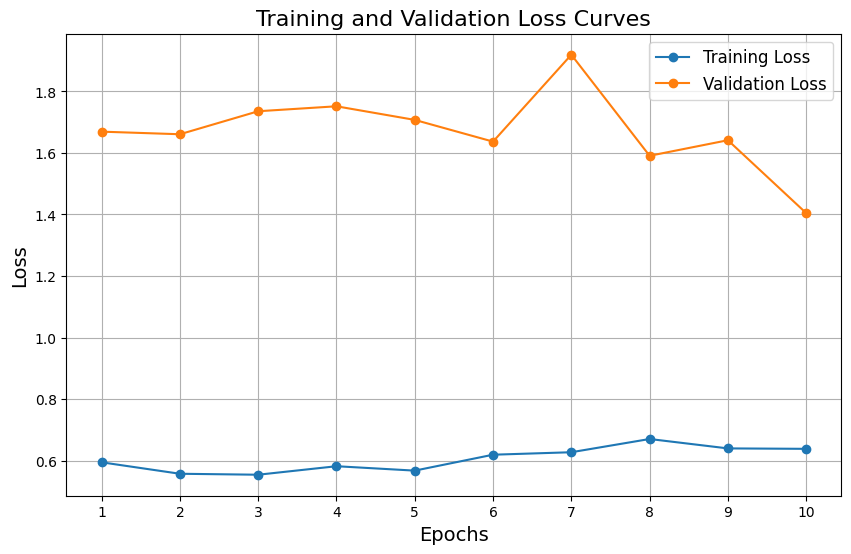

In [10]:
def plot_loss_curves(train_losses, val_losses):
   
    epochs = range(1, len(train_losses) + 1)  

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss Curves', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(epochs)  
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()
plot_loss_curves(train_losses, val_losses)

### Test Loss

In [11]:
test_loss, y_true, y_pred = test_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 1.3529


### GradCAM

Processing Batches:   0%|          | 0/90 [00:00<?, ?it/s]/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


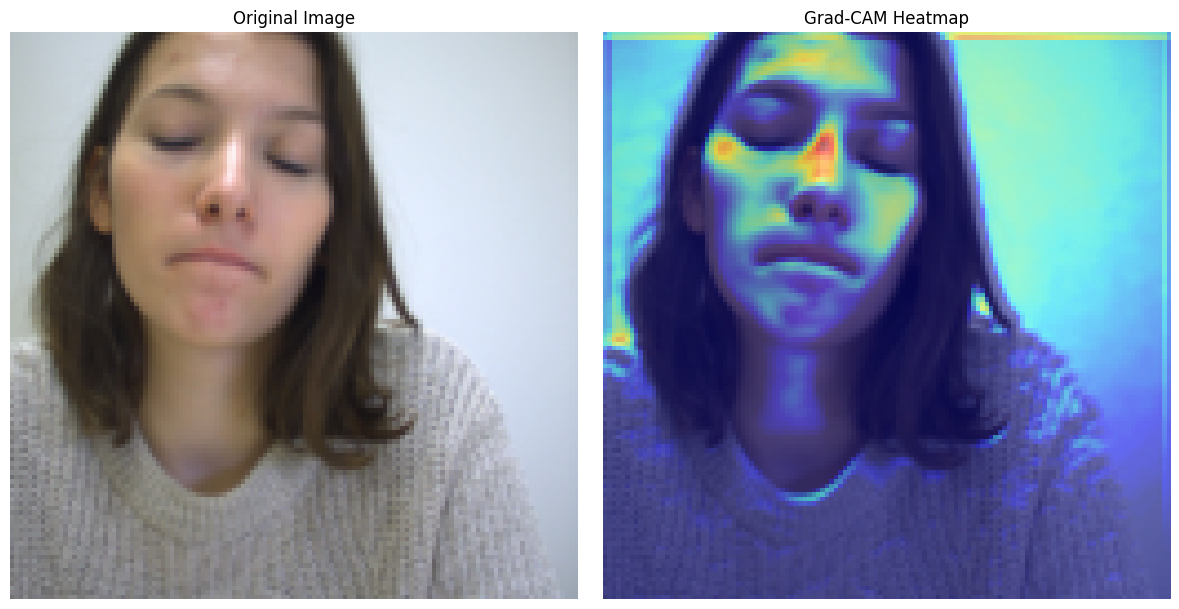

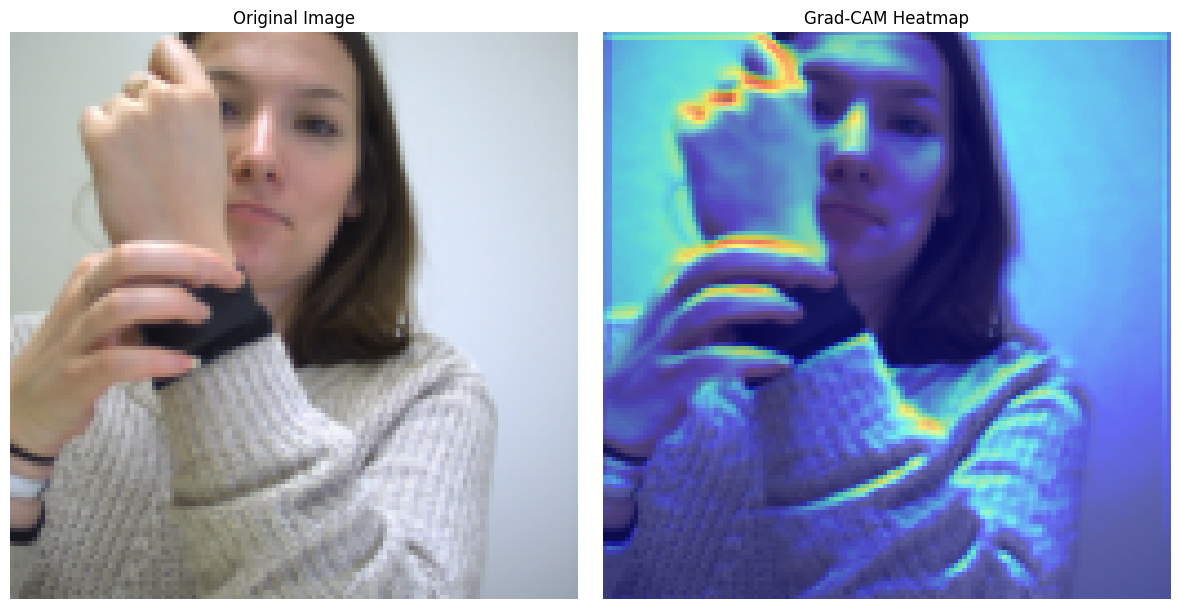

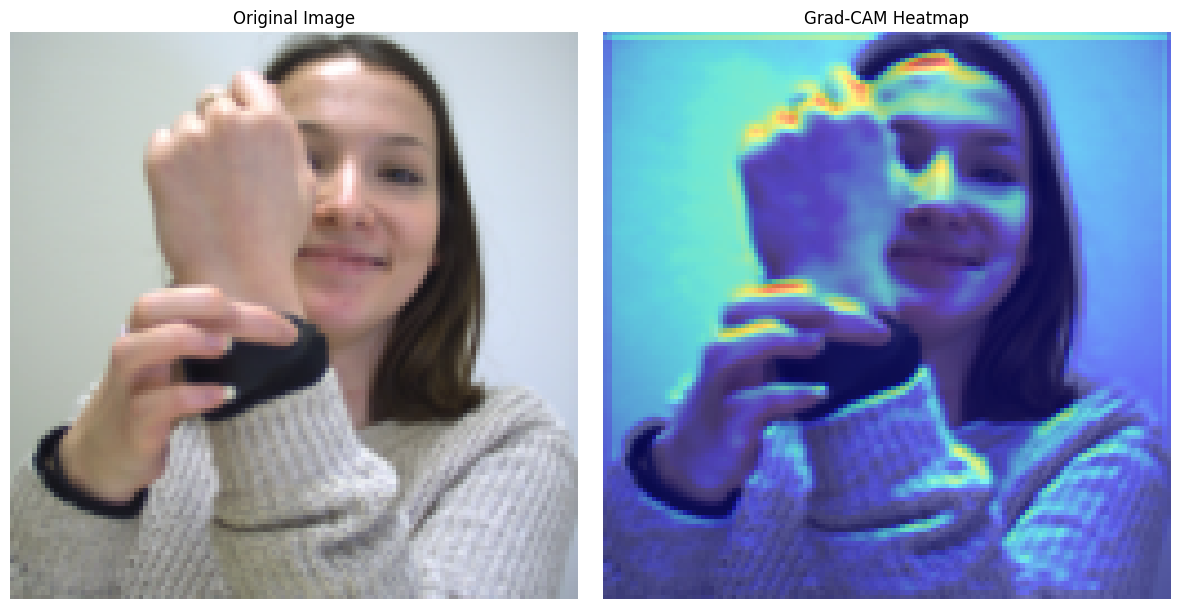

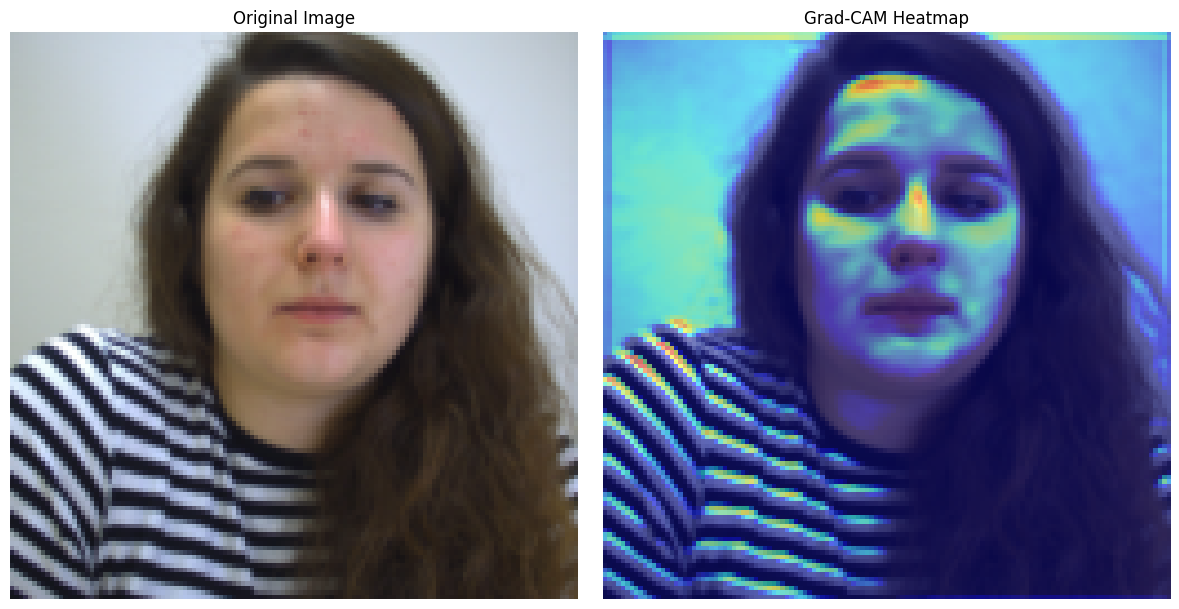

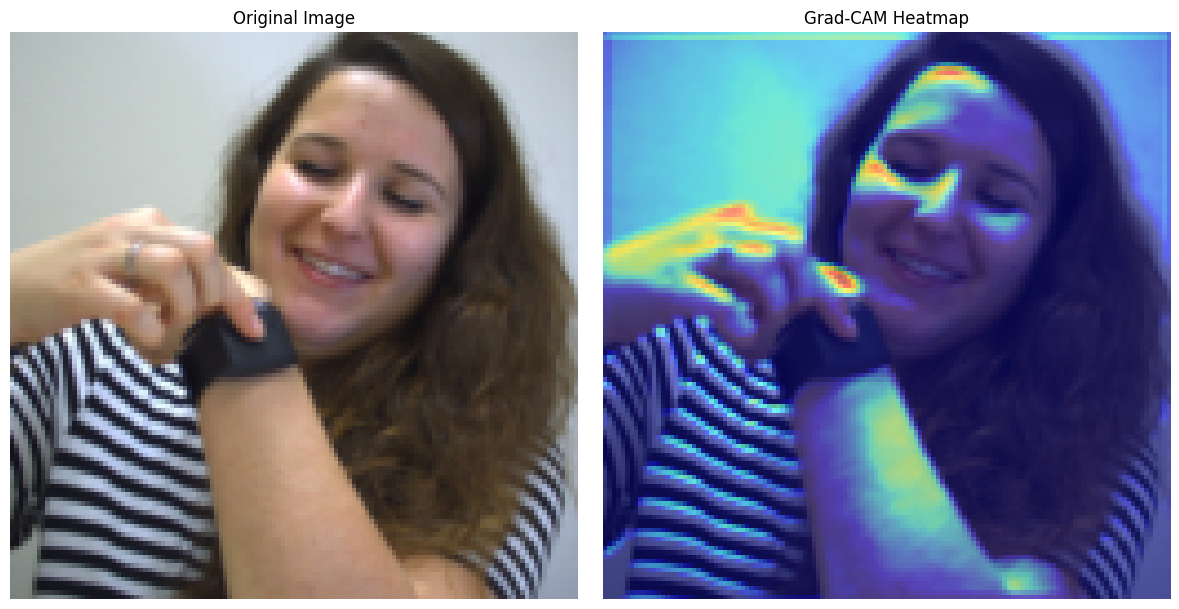

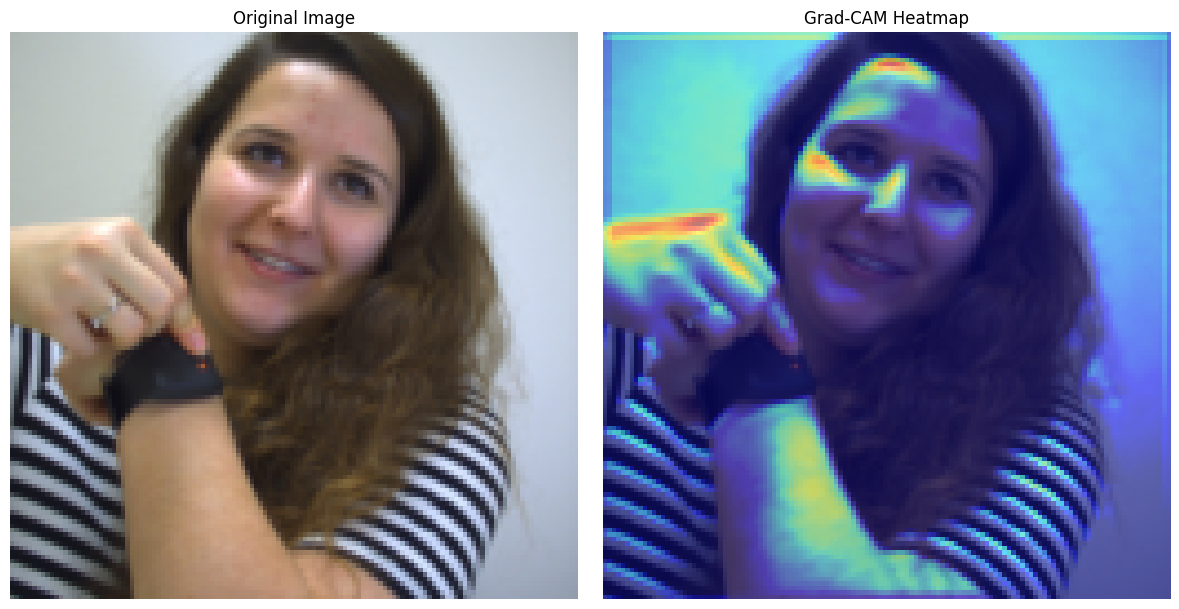

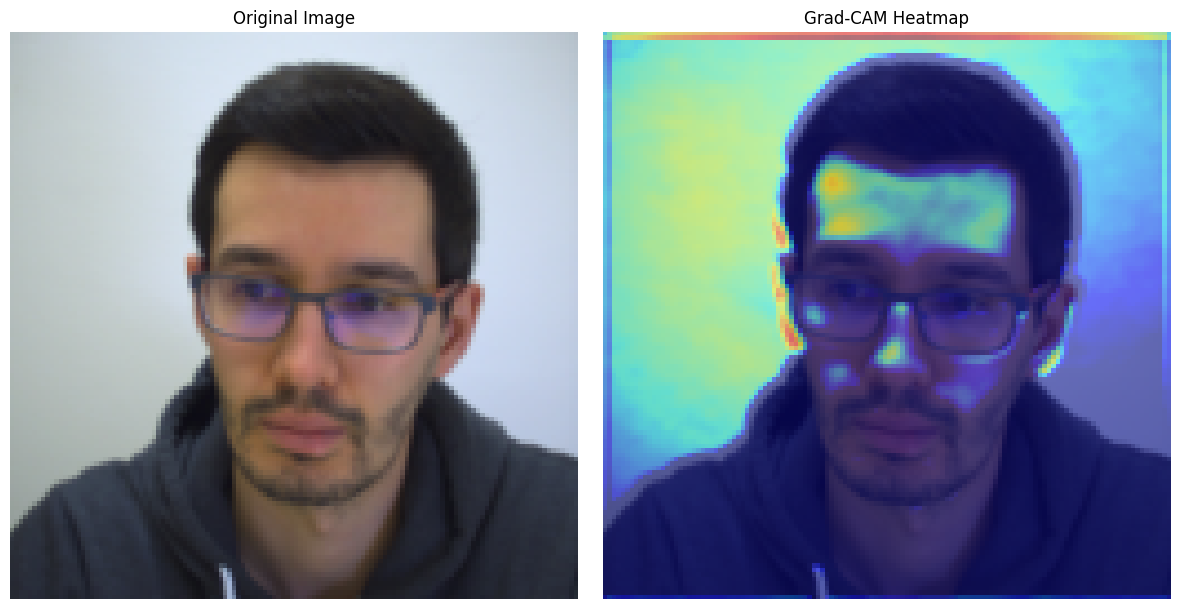

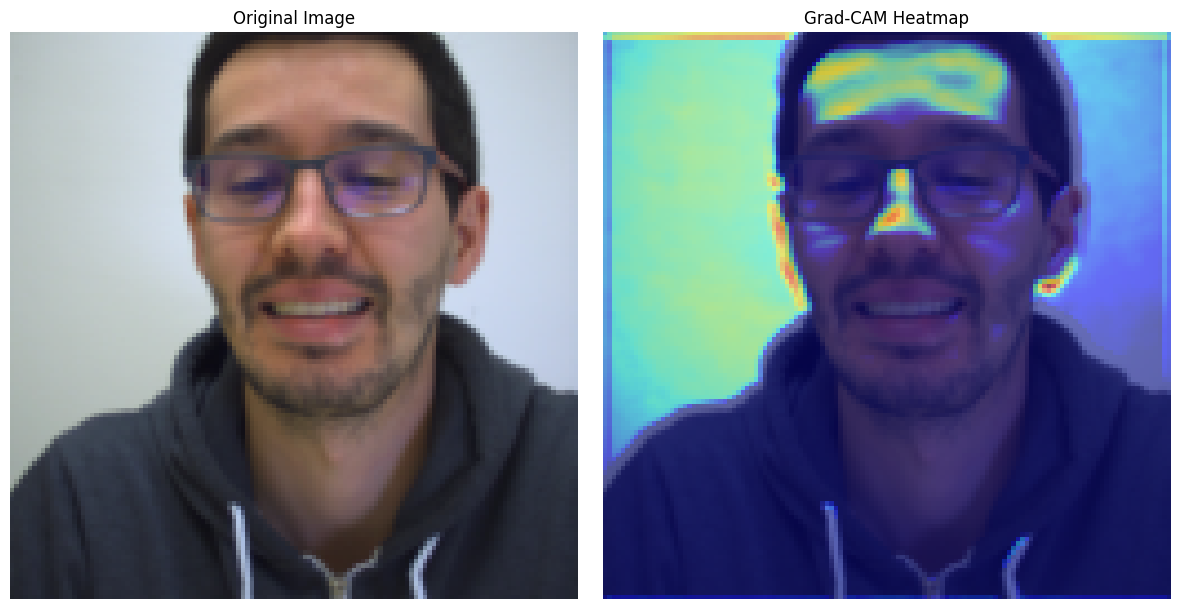

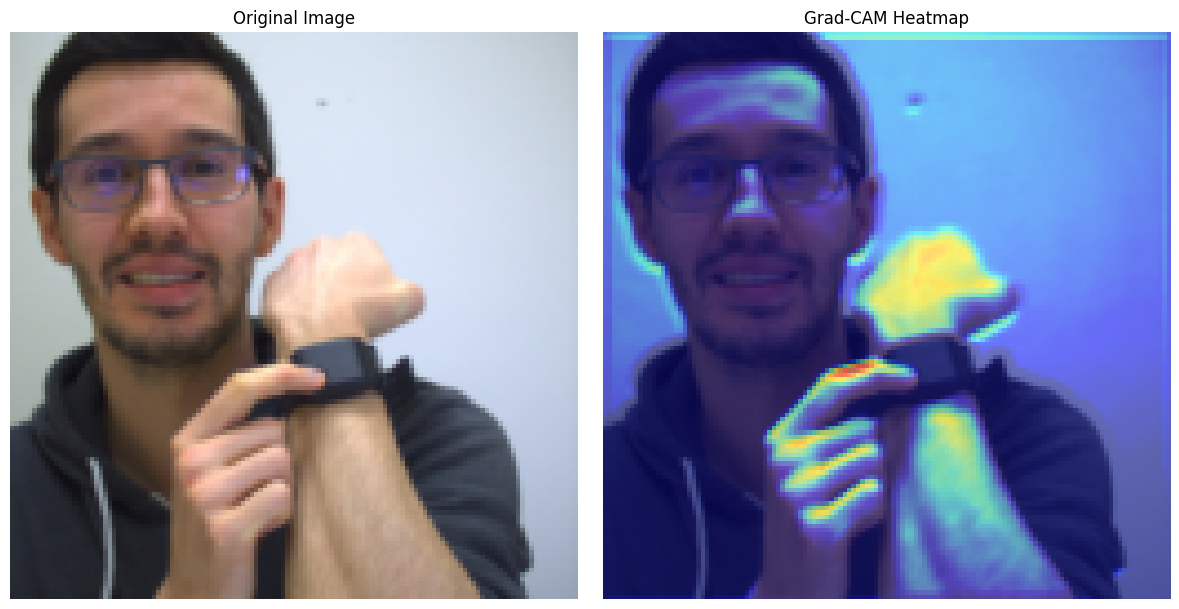

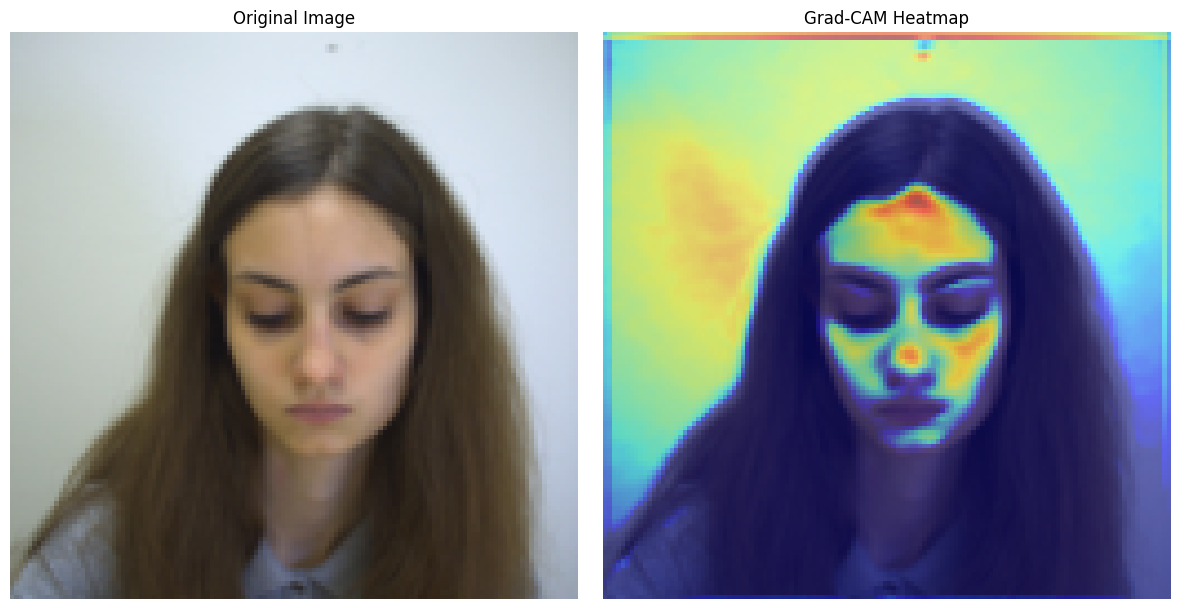

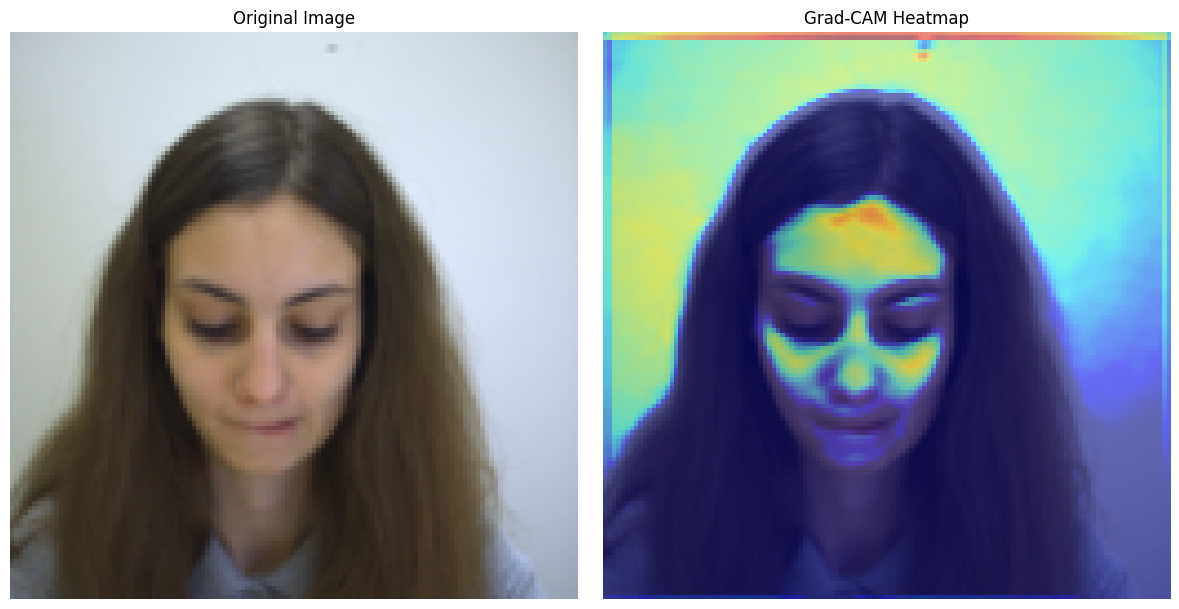

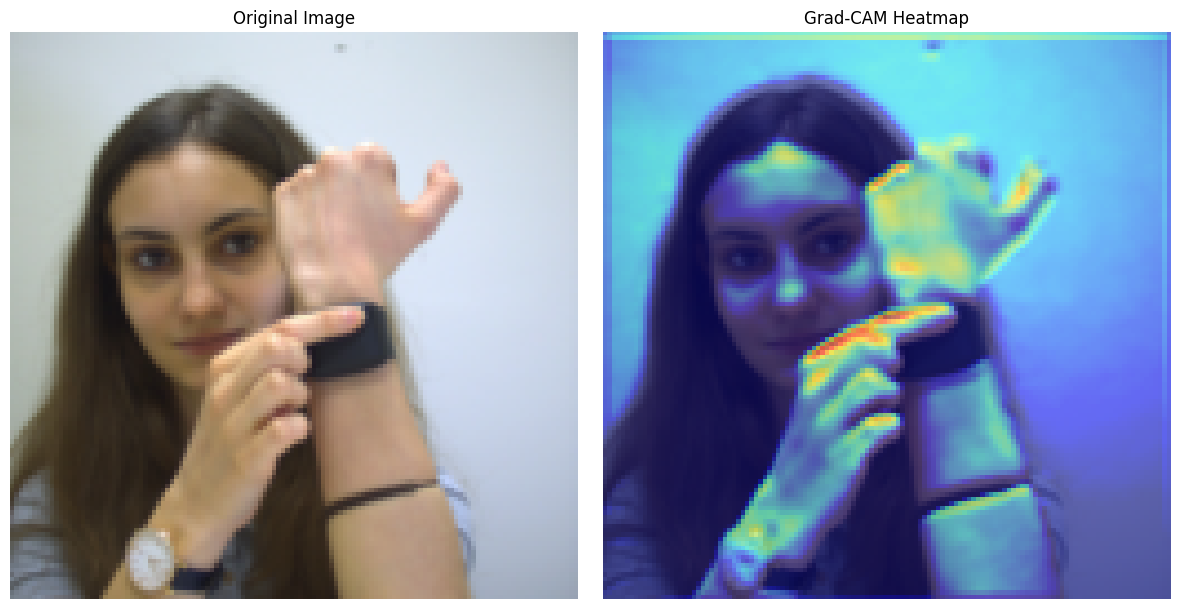

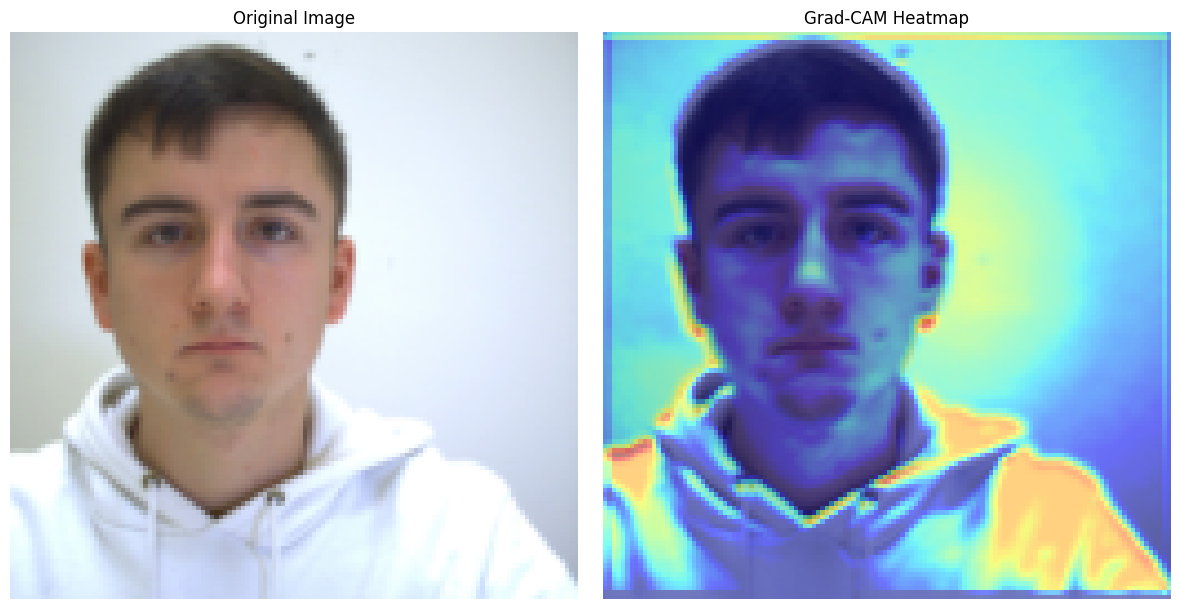

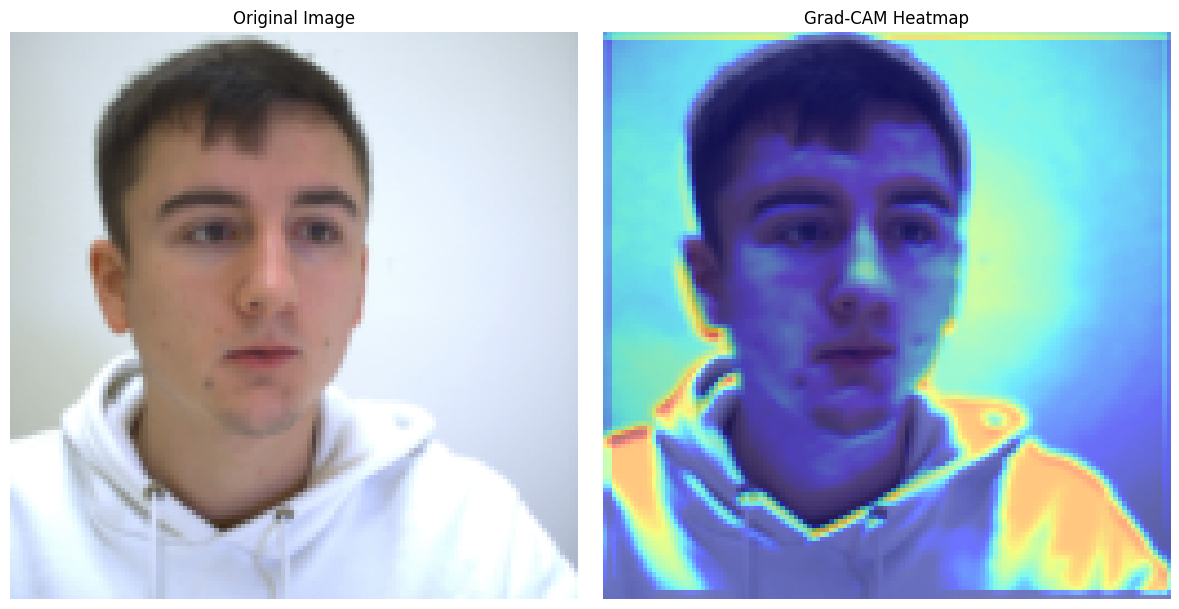

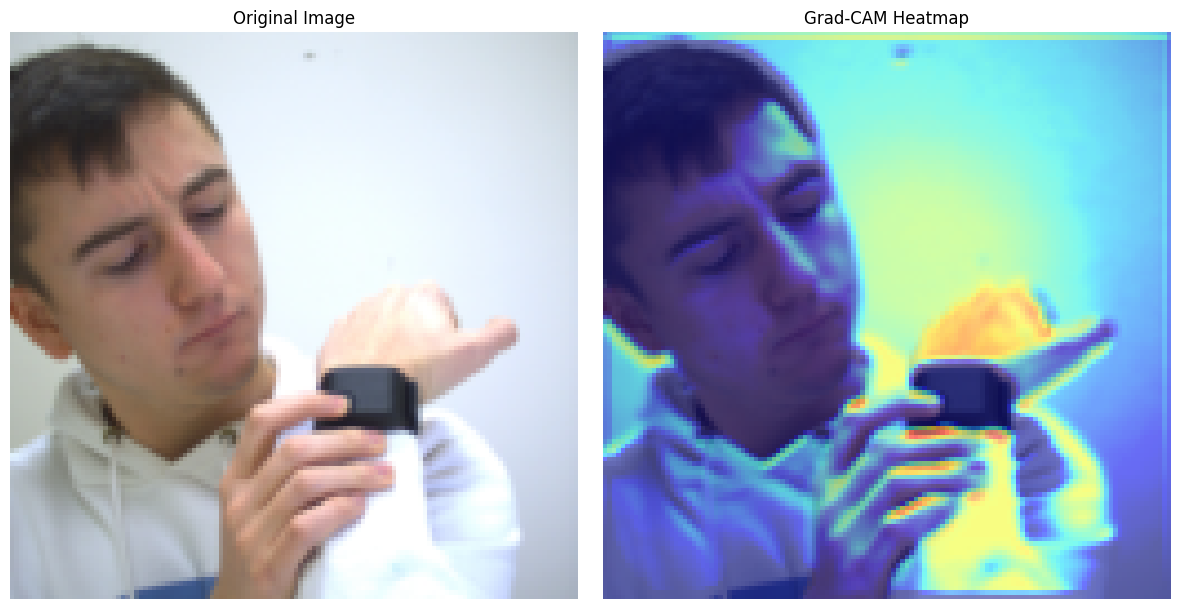

Processing Batches:   0%|          | 0/90 [00:01<?, ?it/s]


In [12]:
visualize_gradcam(
    model=cnn_feature_extractor,
    val_loader=val_loader,
    gradcam_class=GradCAM,
    target_layer=cnn_feature_extractor.conv2,
    num_images=15,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    mean=[0.5, 0.5, 0.5],  
    std=[0.5, 0.5, 0.5],   
    save_plots=False,      
    save_dir='gradcam_plots'
)